# Practice Lab: Neural Networks for Handwritten Digit Recognition, Multiclass 

In this exercise, you will use a neural network to recognize the hand-written digits 0-9.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - ReLU Activation](#2)
- [ 3 - Softmax Function](#3)
  - [ Exercise 1](#ex01)
- [ 4 - Neural Networks](#4)
  - [ 4.1 Problem Statement](#4.1)
  - [ 4.2 Dataset](#4.2)
  - [ 4.3 Model representation](#4.3)
  - [ 4.4 Tensorflow Model Implementation](#4.4)
  - [ 4.5 Softmax placement](#4.5)
    - [ Exercise 2](#ex02)

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
%matplotlib widget

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
tf.autograph.set_verbosity(0)

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests import * 
from autils import *
from lab_utils_softmax import plt_softmax

<a name="2"></a>
## 2 - ReLU Activation
This week, a new activation was introduced, the Rectified Linear Unit (ReLU). 
$$ a = \max(0, z) \quad\quad\text {\# ReLU function} $$

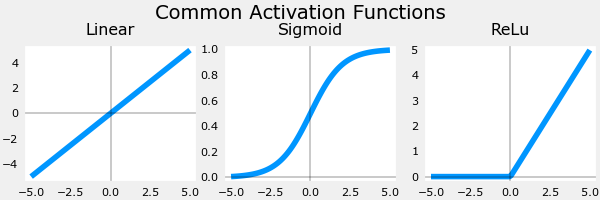

In [2]:
plt_act_trio()

<img align="right" src="./images/C2_W2_ReLu.png"     style=" width:380px; padding: 10px 20px; " >
The example from the lecture on the right shows an application of the ReLU. In this example, the derived "awareness" feature is not binary but has a continuous range of values. The sigmoid is best for on/off or binary situations. The ReLU provides a continuous linear relationship. Additionally it has an 'off' range where the output is zero.     
The "off" feature makes the ReLU a Non-Linear activation. Why is this needed? This enables multiple units to contribute to to the resulting function without interfering. This is examined more in the supporting optional lab.

<a name="3"></a>
## 3 - Softmax Function
A multiclass neural network generates N outputs. One output is selected as the predicted answer. In the output layer, a vector $\mathbf{z}$ is generated by a linear function which is fed into a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will sum to 1. They can be interpreted as probabilities. The larger inputs to the softmax will correspond to larger output probabilities.
<center>  <img  src="./images/C2_W2_NNSoftmax.PNG" width="600" />

The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

Where $z = \mathbf{w} \cdot \mathbf{x} + b$ and N is the number of feature/categories in the output layer.

<a name="ex01"></a>
### Exercise 1
Let's create a NumPy implementation:

In [3]:
# GRADED CELL: my_softmax

def my_softmax(z):
    """
    Softmax converts a vector of values to a probability distribution.

    Args:
        z (ndarray (N,))  : input data, N features
    Returns:
        a (ndarray (N,))  : softmax of z
    """
    ### START CODE HERE ###
    ez = np.exp(z)
    a = ez / np.sum(ez)
    
    ### END CODE HERE ###
    
    return a

In [4]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)

print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

# BEGIN UNIT TEST  
test_my_softmax(my_softmax)
# END UNIT TEST  

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    One implementation uses for loop to first build the denominator and then a second loop to calculate each output.
    
```python
def my_softmax(z):  
    N = len(z)
    a =                     # initialize a to zeros 
    ez_sum =                # initialize sum to zero
    for k in range(N):      # loop over number of outputs             
        ez_sum +=           # sum exp(z[k]) to build the shared denominator      
    for j in range(N):      # loop over number of outputs again                
        a[j] =              # divide each the exp of each output by the denominator   
    return(a)
```
<details>
  <summary><font size="3" color="darkgreen"><b>Click for code</b></font></summary>
   
```python
def my_softmax(z):  
    N = len(z)
    a = np.zeros(N)
    ez_sum = 0
    for k in range(N):                
        ez_sum += np.exp(z[k])       
    for j in range(N):                
        a[j] = np.exp(z[j])/ez_sum   
    return(a)

Or, a vector implementation:

def my_softmax(z):  
    ez = np.exp(z)              
    a = ez/np.sum(ez)           
    return(a)

```

Below, vary the values of the `z` inputs. Note in particular how the exponential in the numerator magnifies small differences in the values. Note as well that the output values sum to one.

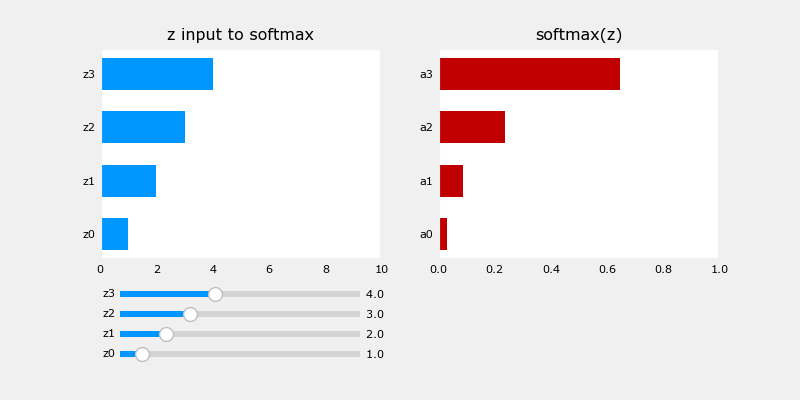

In [5]:
plt.close("all")
plt_softmax(my_softmax)

<a name="4"></a>
## 4 - Neural Networks

In last weeks assignment, you implemented a neural network to do binary classification. This week you will extend that to multiclass classification. This will utilize the softmax activation.


<a name="4.1"></a>
### 4.1 Problem Statement

In this exercise, you will use a neural network to recognize ten handwritten digits, 0-9. This is a multiclass classification task where one of n choices is selected. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. 


<a name="4.2"></a>
### 4.2 Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 5000 training examples of handwritten digits $^1$.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training examples becomes a single row in our data matrix `X`. 
        - This gives us a 5000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 5000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 4` if the image is of the digit `4` and so on.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [6]:
# Load dataset
X, y = load_data()

#### 4.2.1 View the variables
Let's get more familiar with your dataset.  
- A good place to start is to print out each variable and see what it contains.

The code below prints the first element in the variables `X` and `y`.

In [7]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [8]:
print ('The first element of y is: ', y[0, 0])
print ('The last element of y is: ', y[-1, 0])

The first element of y is:  0
The last element of y is:  9


#### 4.2.2 Check the dimensions of your variables

Another way to get familiar with your data is to view its dimensions. Please print the shape of `X` and `y` and see how many training examples you have in your dataset.

In [9]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### 4.2.3 Visualizing the Data

You will begin by visualizing a subset of the training set. 
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image.

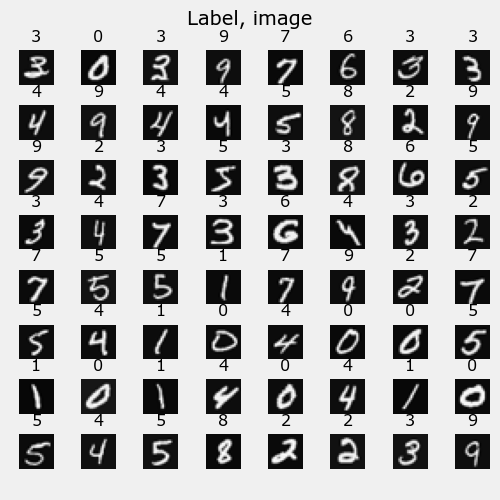

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5, 5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91])      # [left, bottom, right, top]

# fig.tight_layout(pad=0.5)
widgvis(fig)
for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # Reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)